<a href="https://colab.research.google.com/github/mdazab/DATA5322-Homework-4/blob/main/hofidar_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Practical Homework 4: Unsupervised Learning

## Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

## Load Data

In [ ]:
url = "https://raw.githubusercontent.com/mdazab/DATA5322-Homework-4/01ab29286c5ef1532b2ad99474b2236521119465/Hofidar_Cost_Center_Report.csv"
df = pd.read_csv(url)

df.head()

,Year,License Number,Hospital Name,Acct #,Cost Center,ID FTE s,Units of Measure,Salaries Wages,Employee Benefits,Professional Fees,...,Utilities,Other Noncategorized Expenses,Cost Recoveries,Operating Expenses,Allocated Expenses,Plant Sq Feet,Dietary Meals,Housekeeping Hours,Laundry Dry Lbs,Nursing FTE s
0,2018,1,Swedish Health Services DBA Swedish Medical Cent,6010,ICU or Combined ICU-CCU,293.73,29562,30226470,4609431,1896584,...,0,0,1390,41624622,43082868,85986,192205,10901,1292872,192.05
1,2019,1,Swedish Health Services DBA Swedish Medical Cent,6010,ICU or Combined ICU-CCU,315.34,58040,34310765,5176437,2695345,...,0,0,16480,47653505,47164648,85986,225238,11080,1537737,207.90
2,2020,1,Swedish Health Services DBA Swedish Medical Cent,6010,ICU or Combined ICU-CCU,312.25,61858,36778517,5080150,3275253,...,0,0,6556,51674146,47904192,85986,237665,10831,1638252,205.13
3,2021,1,Swedish Health Services DBA Swedish Medical Cent,6010,ICU or Combined ICU-CCU,283.63,56193,36710859,4990817,3525876,...,0,0,33657,51660408,48273323,85986,0,386564,15922,181.60
4,2022,1,Swedish Health Services DBA Swedish Medical Cent,6010,ICU or Combined ICU-CCU,309.64,13801,23232296,1105754,198446,...,0,77151,0,28887656,0,50191,0,7496,0,189.40


## Remove Categorial Variables

In [ ]:
cat_names = df[['Year', 'License Number', 'Hospital Name', 'Acct #', 'Cost Center', 'Units of Measure']]
df_clean = df.drop(columns=['Year', 'License Number', 'Hospital Name', 'Acct #', 'Cost Center', 'Units of Measure'])


## Data QC

### Checking columns with Zeros, NaN or empty strings

In [ ]:
empty_string_count = (df.astype(str).apply(lambda x: x.str.strip()) == '').sum()
df_vis = df_clean.apply(pd.to_numeric, errors='coerce')

n_rows = len(df_vis)


summary = pd.DataFrame({
    'Zero Count': (df_vis == 0).sum(),
    'NaN Count': df_vis.isna().sum(),
    'Empty String Count': empty_string_count
})
summary['Zero %'] = (summary['Zero Count'] / n_rows) * 100
summary['NaN %'] = (summary['NaN Count'] / n_rows) * 100
summary['Empty String %'] = (summary['Empty String Count'] / n_rows) * 100

summary = summary[(summary['Zero Count'] > 0) |
                  (summary['NaN Count'] > 0) |
                  (summary['Empty String Count'] > 0)]

summary = summary.sort_values(by='Zero Count', ascending=False)

summary.style.format({
    'Zero %': '{:.2f}%',
    'NaN %': '{:.2f}%',
    'Empty String %': '{:.2f}%',
    'Zero Count': '{:,}',
    'NaN Count': '{:,}',
    'Empty String Count': '{:,}'
})



,Zero Count,NaN Count,Empty String Count,Zero %,NaN %,Empty String %
Purchased Laboratory Services,"43,107.0",0.0,0,99.75%,0.00%,0.00%
Legal Audit and Tax services,"43,023.0",0.0,0,99.55%,0.00%,0.00%
Blood Supplies,"42,981.0",0.0,0,99.45%,0.00%,0.00%
Staff Recruitment,"42,740.0",0.0,0,98.90%,0.00%,0.00%
Laundry Services,"42,703.0",0.0,0,98.81%,0.00%,0.00%
Insurance and Professional Liability,"42,647.0",0.0,0,98.68%,0.00%,0.00%
Taxes,"42,617.0",0.0,0,98.61%,0.00%,0.00%
Utilities,"42,490.0",0.0,0,98.32%,0.00%,0.00%
Shared Services or System Office Allocation,"42,488.0",0.0,0,98.31%,0.00%,0.00%
Information Technology Including Licenses and Maintenance,"42,445.0",0.0,0,98.21%,0.00%,0.00%


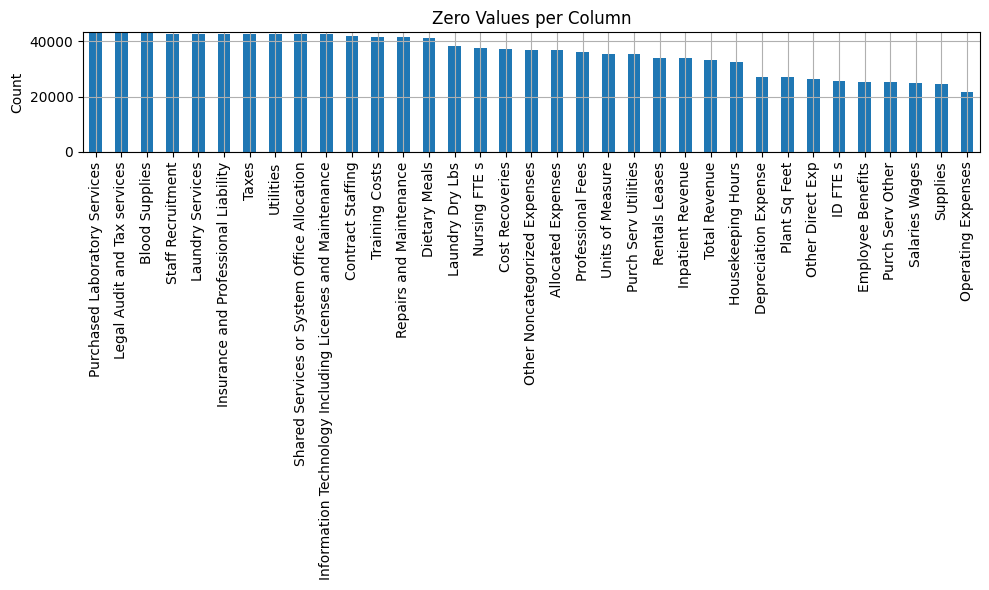

In [ ]:
zero_counts = (df_vis == 0).sum().sort_values(ascending=False)
zero_counts = zero_counts[zero_counts > 0]

plt.figure(figsize=(10, 6))
zero_counts.plot(kind='bar')
plt.ylim(0, len(df_vis))
plt.title("Zero Values per Column")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()




### Checking for Min and Max Values

In [ ]:
df_clean.agg(['min','max'])

,ID FTE s,Units of Measure,Salaries Wages,Employee Benefits,Professional Fees,Supplies,Purch Serv Utilities,Purch Serv Other,Rentals Leases,Depreciation Expense,...,Utilities,Other Noncategorized Expenses,Cost Recoveries,Operating Expenses,Allocated Expenses,Plant Sq Feet,Dietary Meals,Housekeeping Hours,Laundry Dry Lbs,Nursing FTE s
min,-36.48,-4242,-761454,-109155505,-1049285,-6926603,-103178,-19253644,-30881934,-2504590,...,-600,-5885978,-85074181,-298080796,-1734373,0,0,0,0,-0.15
max,97033.00,13032476,290573711,72545047,172233103,452097193,10322174,280565951,16927101,47003801,...,13601931,448780010,1091802923,907130783,123161645,1117328,1973965,1387160,8077503,69379.25


In [ ]:
df['Hospital Name'].nunique()

107

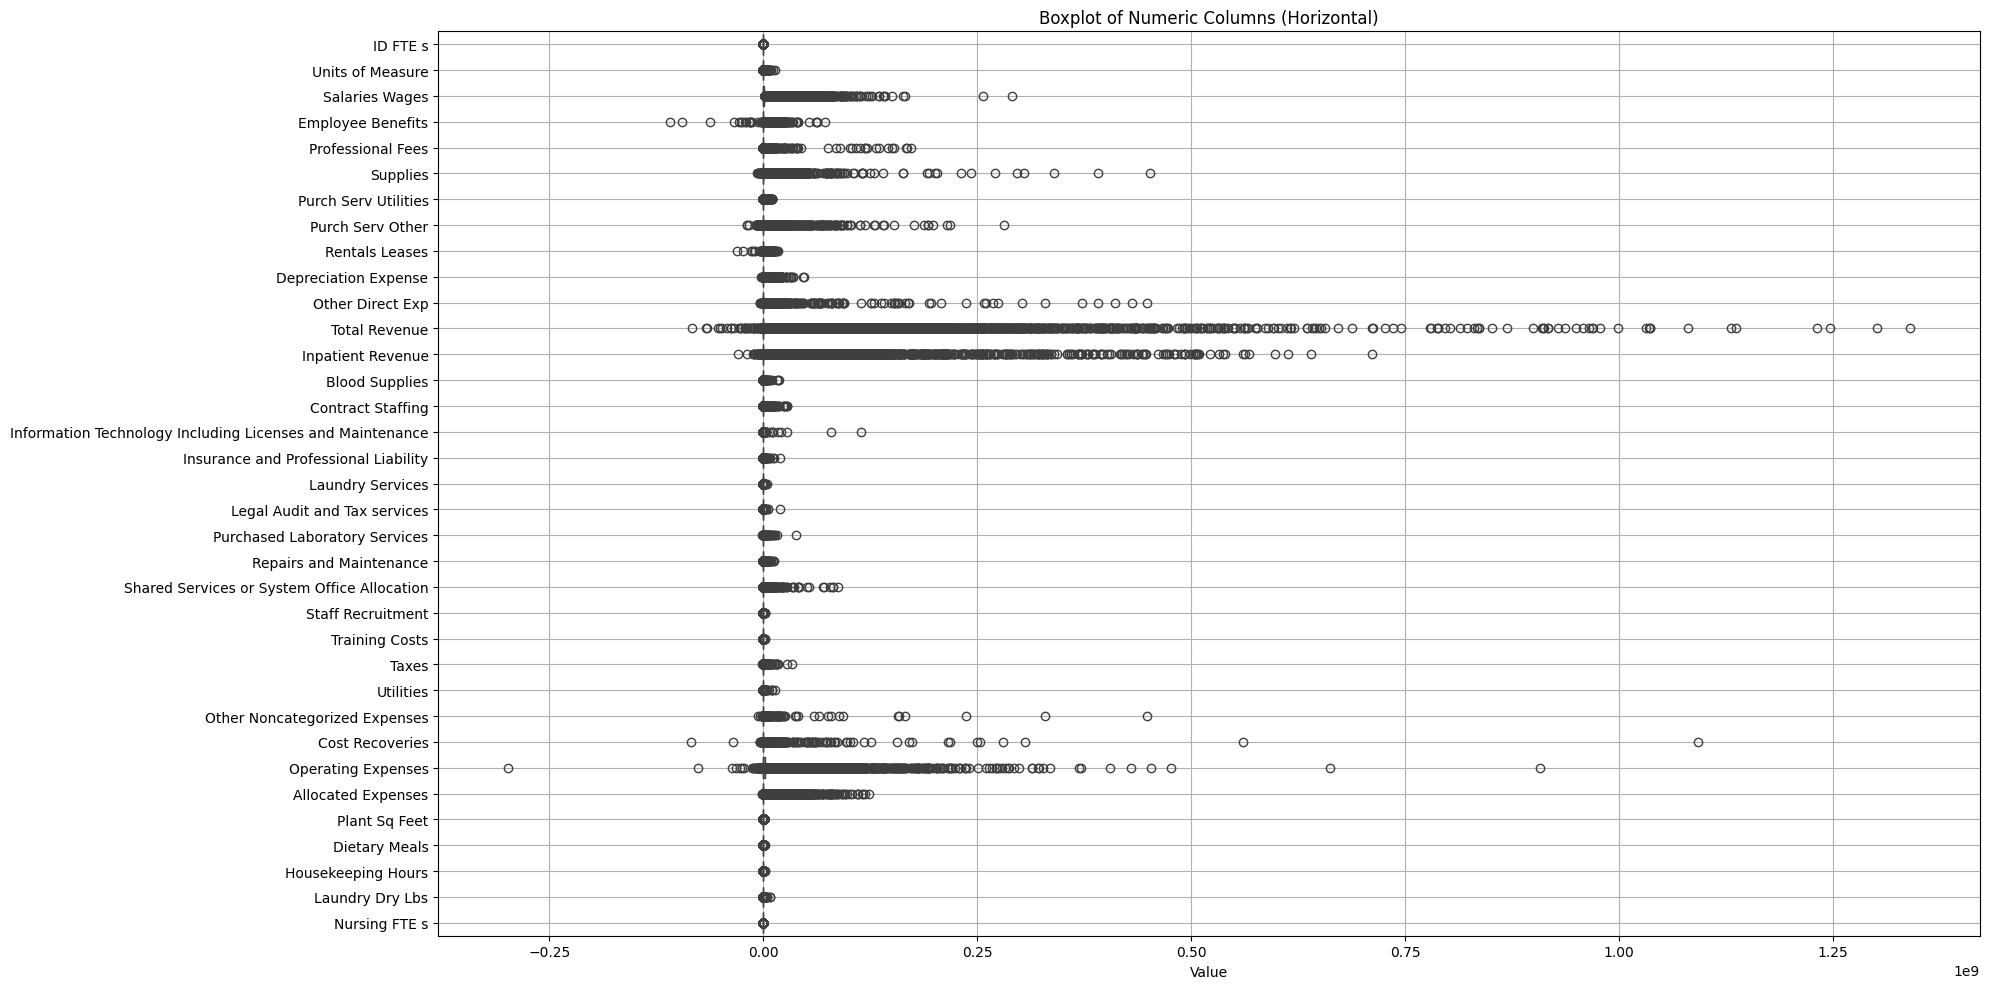

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_vis, orient='h')
plt.title("Boxplot of Numeric Columns (Horizontal)")
plt.xlabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
neg_counts_by_column = (
    df[df.select_dtypes(include='number').lt(0).any(axis=1)]
    .melt(value_vars=df.select_dtypes(include='number').columns)
    .query('value < 0')
    .groupby('variable')
    .size()
    .reset_index(name='Negative Count')
    .sort_values(by='Negative Count', ascending=False)
)

print(neg_counts_by_column.to_string(index=False))

                                                 variable  Negative Count
                                                 Supplies             471
                                         Other Direct Exp             394
                                       Operating Expenses             335
                                         Purch Serv Other             298
                                           Rentals Leases             231
                            Other Noncategorized Expenses             211
                                          Cost Recoveries             199
                                        Professional Fees             162
                                        Inpatient Revenue             118
                                            Total Revenue              90
                                        Employee Benefits              89
                                        Contract Staffing              78
                                     P

####  Columns with Negative Values

- Financial: Salaries Wages, Supplies, Depreciation Expense, Total Revenue
- Staffing: ID FTEs, Nursing FTEs
- Resources: Utilities, Purchased Laboratory **Services**

### Commonalities between columns with Negative Values

In [ ]:
neg_summary = (
    df[df.select_dtypes(include='number').lt(0).any(axis=1)]
    .groupby(['Cost Center'])
    .size()
    .reset_index(name='Count')
    .sort_values(by='Count', ascending=False)
)

print(neg_summary.to_string(index=False))


                        Cost Center  Count
               Other Admin Services    168
                         Purchasing    139
                   Central Services    134
            Hospital Administration     94
                            Dietary     64
           Other Ancillary Services     64
                  Laundry and Linen     53
             Other General Services     51
             Radiology - Diagnostic     47
                         Acute Care     47
                         Anesthesia     42
                              Plant     40
                            Clinics     40
                          Personnel     39
                       Housekeeping     38
                   Physical Therapy     38
                   Patient Accounts     37
                    Data Processing     37
                           Pharmacy     36
             Nursing Administration     35
Accounting or Total Fiscal Services     35
                Respiratory Therapy     34
           

#### What should we do?
- Remove the cost center with negative adjustments/refunts/data entry errors?

#### Solution to Zero values in dataset
Aggregate values by Hospital and Year
- It will help us reduce the noise from cost centers with lots of missing data
- Allows for bettter handling of missing data, easier to impute at hospital-level
- We can focus on hospital-wide trends, not departmental operations
- Results would focus on spending or revenue
- Easier data preparation for PCA, clustering

### Data Aggregated

In [ ]:
df_agg = df.groupby(['Hospital Name', 'Year'], as_index=False).sum(numeric_only=True)
df_agg.describe()


,Year,License Number,Acct #,ID FTE s,Units of Measure,Salaries Wages,Employee Benefits,Professional Fees,Supplies,Purch Serv Utilities,...,Utilities,Other Noncategorized Expenses,Cost Recoveries,Operating Expenses,Allocated Expenses,Plant Sq Feet,Dietary Meals,Housekeeping Hours,Laundry Dry Lbs,Nursing FTE s
count,566.000000,566.000000,566.000000,566.000000,5.660000e+02,5.660000e+02,5.660000e+02,5.660000e+02,5.660000e+02,5.660000e+02,...,5.660000e+02,5.660000e+02,5.660000e+02,5.660000e+02,5.660000e+02,5.660000e+02,5.660000e+02,5.660000e+02,5.660000e+02,566.000000
mean,2020.643110,13823.962898,584164.893993,1310.704081,2.418578e+06,1.153027e+08,2.411402e+07,1.303145e+07,5.149089e+07,1.896263e+06,...,2.134833e+05,5.844759e+06,1.928849e+07,2.922959e+08,5.259605e+07,3.772668e+05,1.252131e+05,1.097257e+05,8.010679e+05,433.369735
std,1.809468,16833.898938,88099.158635,4301.365417,4.068454e+06,1.566191e+08,3.510042e+07,2.788329e+07,8.610424e+07,2.807009e+06,...,1.313928e+06,3.147067e+07,7.650348e+07,4.007025e+08,1.086694e+08,4.994270e+05,2.167652e+05,4.199631e+05,1.732177e+06,2952.122512
min,2018.000000,8.000000,9000.000000,0.000000,0.000000e+00,0.000000e+00,-1.627202e+06,-7.251000e+03,-1.447030e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,-1.376640e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2019.000000,4666.500000,601720.000000,184.110000,1.821770e+05,1.482129e+07,3.388254e+06,1.550579e+06,2.171296e+06,2.575232e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,3.244036e+07,0.000000e+00,7.021650e+04,8.108500e+03,1.065000e+04,3.455425e+04,41.477500
50%,2021.000000,11120.000000,610720.000000,502.600000,7.847020e+05,4.134682e+07,8.312048e+06,4.863402e+06,1.423115e+07,7.946115e+05,...,0.000000e+00,0.000000e+00,7.869140e+05,1.027708e+08,4.795185e+06,1.587980e+05,3.405550e+04,3.871150e+04,2.400475e+05,112.470000
75%,2022.000000,14833.500000,610720.000000,1451.792500,2.526792e+06,1.488031e+08,2.919634e+07,1.187731e+07,6.695834e+07,2.359007e+06,...,0.000000e+00,8.098582e+05,1.045266e+07,4.133790e+08,4.637464e+07,5.735058e+05,1.518825e+05,1.088110e+05,9.914502e+05,377.970000
max,2024.000000,74240.000000,610720.000000,97253.940000,3.438331e+07,9.360426e+08,2.529480e+08,2.444690e+08,5.993350e+08,1.680769e+07,...,1.786008e+07,4.646916e+08,1.261258e+09,2.915316e+09,7.397069e+08,3.200145e+06,2.123480e+06,6.418778e+06,2.447000e+07,69794.250000


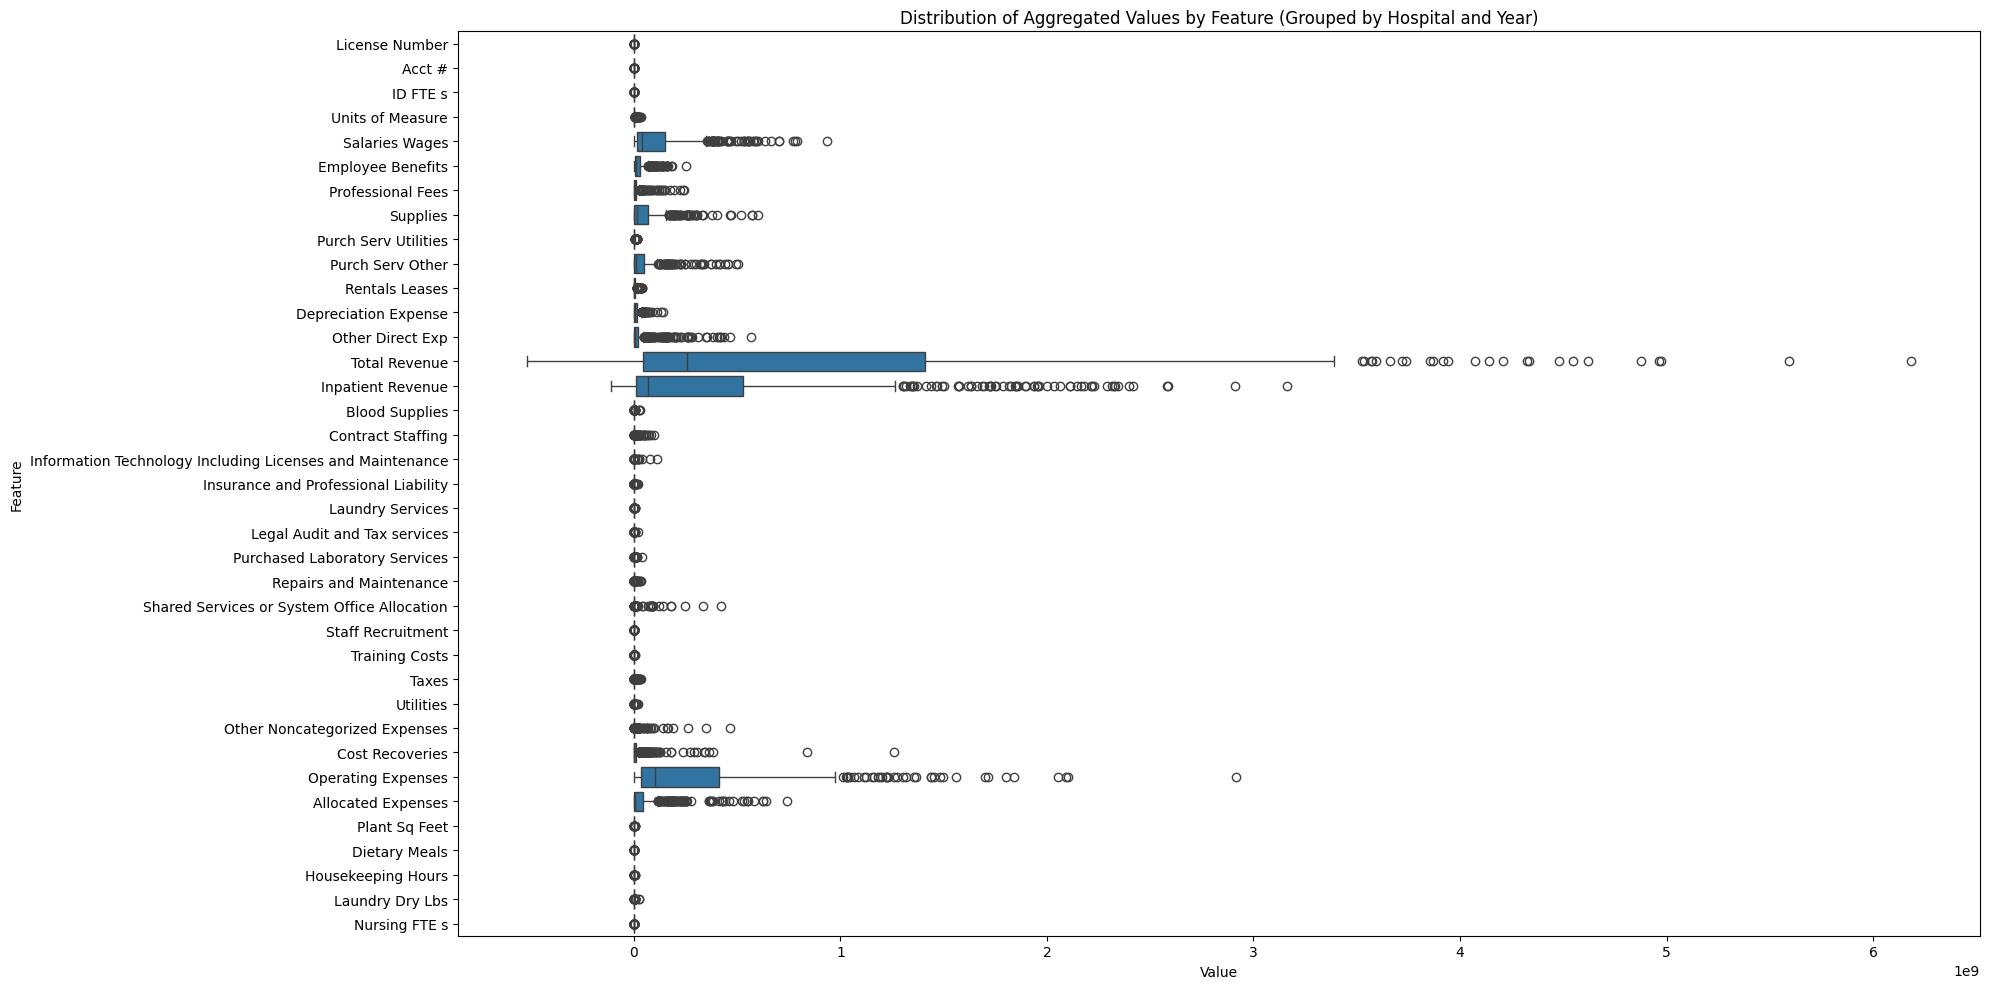

In [ ]:
df_grouped = df.groupby(['Hospital Name', 'Year'], as_index=False).sum(numeric_only=True)
df_melted = df_grouped.melt(id_vars=['Hospital Name', 'Year'], var_name='Feature', value_name='Value')

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_melted, x='Value', y='Feature', orient='h')
plt.title("Distribution of Aggregated Values by Feature (Grouped by Hospital and Year)")
plt.xlabel("Value")
plt.tight_layout()
plt.show()

### Use df_agg from now on